<a href="https://colab.research.google.com/github/Jinyu-Luo/16-CHL5230-Datathon2/blob/main/16_CHL5230_F23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import neighbors
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [2]:
# upload the data
from google.colab import files
uploaded = files.upload()

Saving Mortality.csv to Mortality.csv


In [3]:
df = pd.read_csv(io.BytesIO(uploaded['Mortality.csv']))

In [4]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


The dataset contains the following attributes:

*   **age**: Age of the patient.
*   **anaemia**: A binary indicator (0 for No, 1 for Yes) suggesting if the patient has anemia.
*   **creatinine_phosphokinase**: Level of the CPK enzyme in the blood (mcg/L). An increased amount can be indicative of damage to the heart or other muscles.
*   **diabetes**: A binary indicator (0 for No, 1 for Yes) suggesting if the patient has diabetes.
*   **ejection_fraction**: Percentage of blood leaving the heart at each contraction. A typical range is between 50% and 70%. Lower percentages may indicate heart failure.
*   **high_blood_pressure**: A binary indicator (0 for No, 1 for Yes) suggesting if the patient has high blood pressure or hypertension.
*   **platelets**: Platelets in the blood (kiloplatelets/mL). They are tiny blood cells that help the body form clots to stop bleeding.
*   **serum_creatinine**: Level of serum creatinine in the blood (mg/dL). It measures kidney function, and higher levels might indicate poorer kidney function.
*   **serum_sodium**: Level of serum sodium in the blood (mEq/L). It's an essential electrolyte that helps regulate water balance, pH, and nerve signals.
*   **sex**: Binary indicator (1 for Male, 0 for Female).
*   **smoking**: A binary indicator (0 for No, 1 for Yes) suggesting if the patient smokes or not.
*   **time**: This seems like some form of time indicator. It could be the duration of observation/follow-up (e.g., days from initial measurement).
*   **DEATH_EVENT**: The target variable, a binary indicator (0 for No, 1 for Yes) suggesting if the patient died from a cardiovascular complication.

**Research Objective**:

Given the attributes in the dataset, our group aims to understand different risk factors and their relative importance in predicting the occurence of death.

**Reserch Questions**:

1. Can we predict death in NYHA C3 or C4 patients given various clinical and demographic variables?

2. Which variable contributes the greatest to predicting death?

**Initial Thoughts**:

Attributes in the dataset can be grouped into three categories:
1) We are given several features which are kept as continuous variables. These can be useful in linear regression modelling. However, to provide additional context for each variable, we will transform them as above to categorical variables as a way to explore their importance in logistic regression.


## Data Exploration

Frist, print the summary statistics to understand the distribution of the data.

In [5]:
description = df.describe()
description

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


- The age range of the patients is between 40 to 95 years, with a median of 60.

- 65% of the patients are males

- The CPK enzyme value has a minimum of 23 and a maximum of 7861. The standard deviation is quite large, suggesting a high variability in this feature. The majority have a value below 582, and those extreme values might be skewing the mean.

- The ejection fraction ranges from 14 to 80, and its mean and median are quite close, suggesting a relatively normal distribution.

#### Check Missing Values

In [6]:
# Check the number of missing values for each column
missing_values = df.isnull().sum()

# Print the columns with missing values and their count
print(missing_values[missing_values > 0])

Series([], dtype: int64)


No missing value is detected.

#### Correlation Matrix

<Axes: >

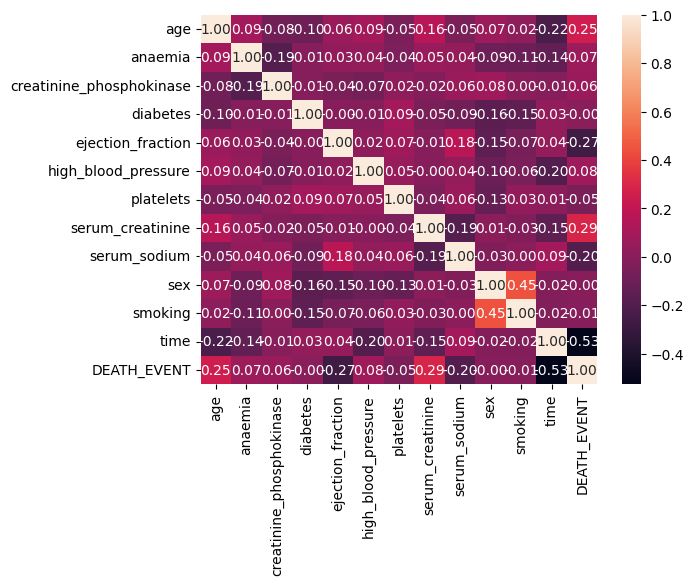

In [7]:
# Correlation matrix to quantify relationships
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f")


#### Categorical Variables

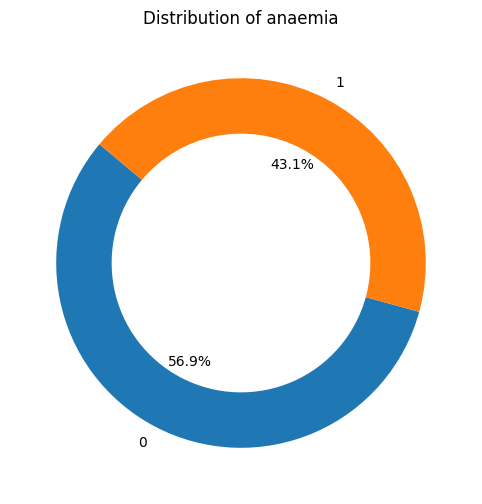

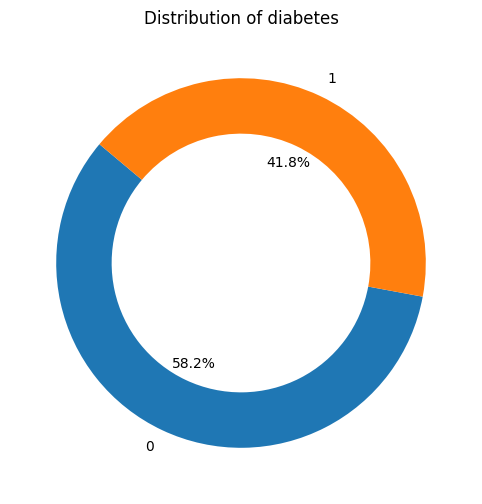

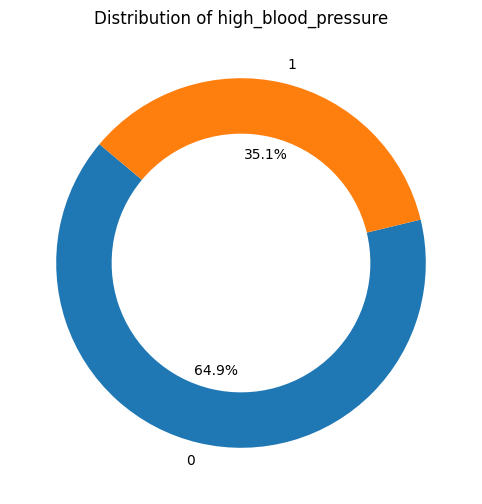

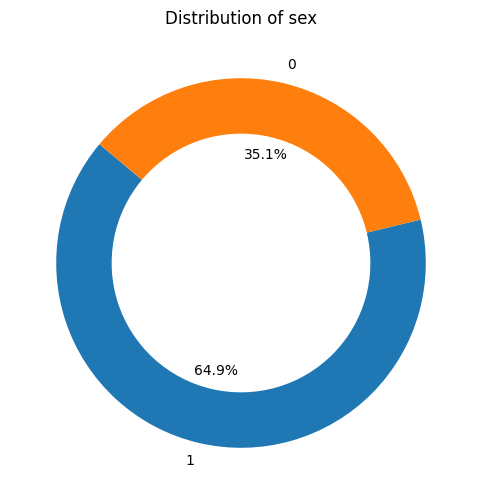

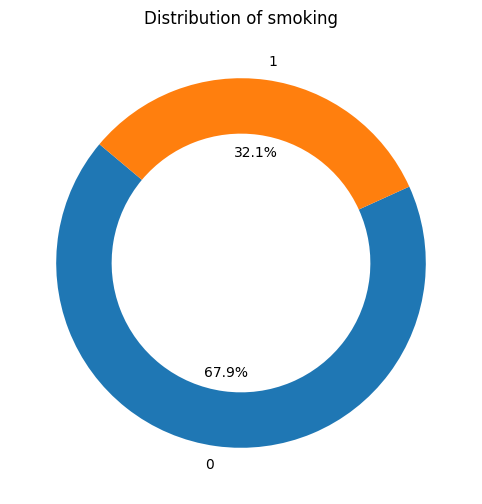

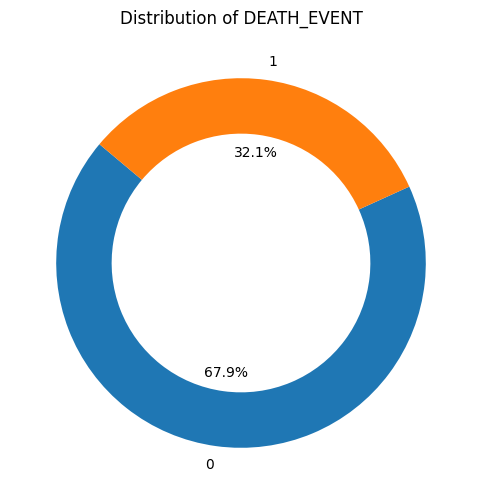

In [8]:
categoricals = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'DEATH_EVENT']
for col in categoricals:
  # get the count of each category
  counts = df[col].value_counts()

  # plot
  plt.figure(figsize = (8, 6))
  plt.pie(counts, labels = counts.index, autopct = '%1.1f%%',
          startangle = 140, wedgeprops = dict(width = 0.3))
  plt.title(f'Distribution of {col}')
  plt.show()

**Observation**:

- Among the participants, 43.1% of the patients suffer from anaemia, while 41.8% have been diagnosed with diabetes. A significant 64.9% of the patients do not exhibit high blood pressure. In terms of demographics, females comprises 35.1% of the cohort, and 32.1% of the population currently smoke. Lastly, 32.1% experienced a death event within the observed time period.

#### Numerical Variables

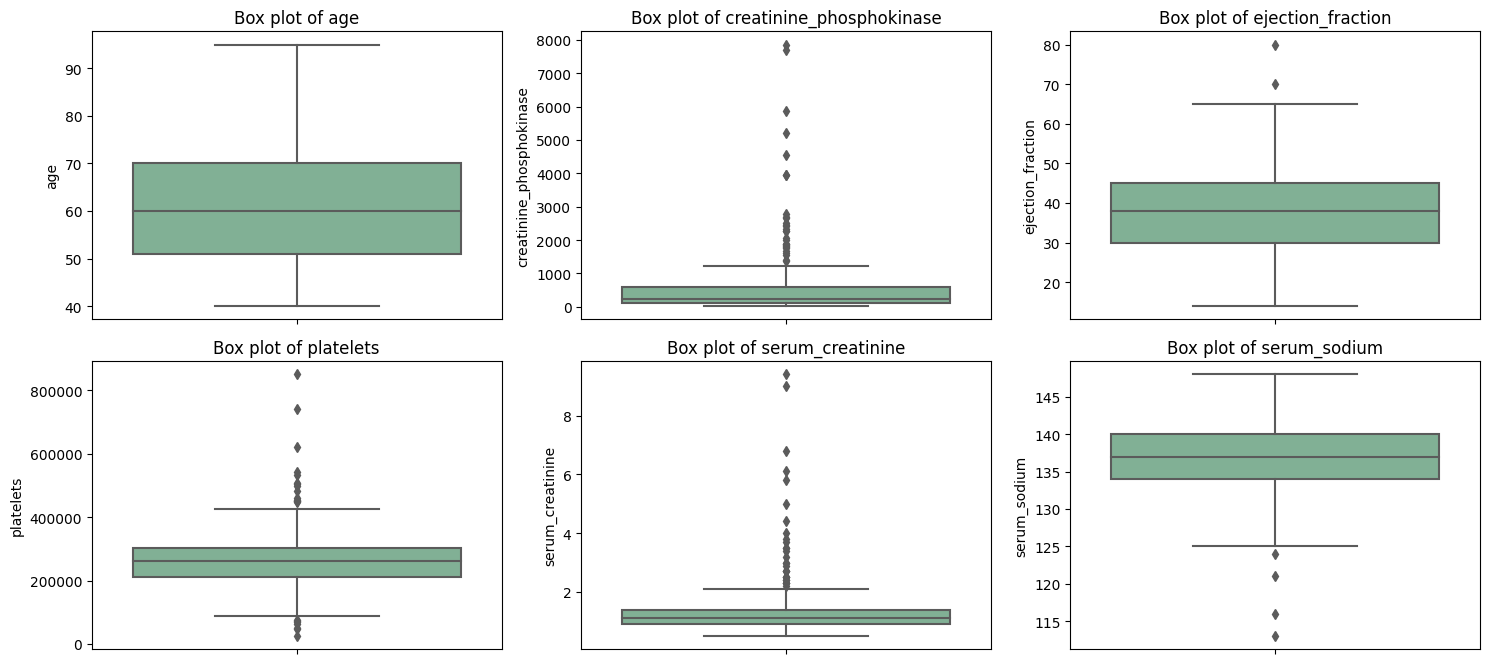

In [10]:
numerical = description.drop('count')
numerical= description.drop(['time', 'anaemia','diabetes', 'high_blood_pressure',
                               'sex', 'smoking', 'DEATH_EVENT'], axis = 1)

# Visualize the summary statistics
plt.figure(figsize = (15, 10))

# Use the default cube helix color palette
color = sns.color_palette("ch:2.5,-.2,dark=.3")

for i, feature in enumerate(numerical, 1):
    plt.subplot(3, 3, i)  # Adjust subplot dimensions based on the number of features
    sns.boxplot(y=df[feature], color=color[2])
    plt.title(f'Box plot of {feature}')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

**Observations**:

- Except age and time, outliers are observed in the rest numerical variables.

- Note that only two outliers were detected in Ejection Fraction, so we can consider to remove this two observations first.

- Extremely high values in Creatinine Phosphokinase and Serum Creatinine could be indicative of certain medical conditions. We can consider use log transformation to address those outliers.

  - Elevated levels of serum creatinine can indicate impaired kidney function or kidney disease.

  - High CPK values can indicate muscles damage, including heart attacks.

- Since outliers in Platelets are on both sides, we can consider to use Interquartile Range to scale the data, as it is less sensitive to outliers than standard scaling methods.

- Lots of low values shown up on the box plot of serum sodium, which might be clinically significant. We might consider to use robust scaling or winsorizing to address these outliers.

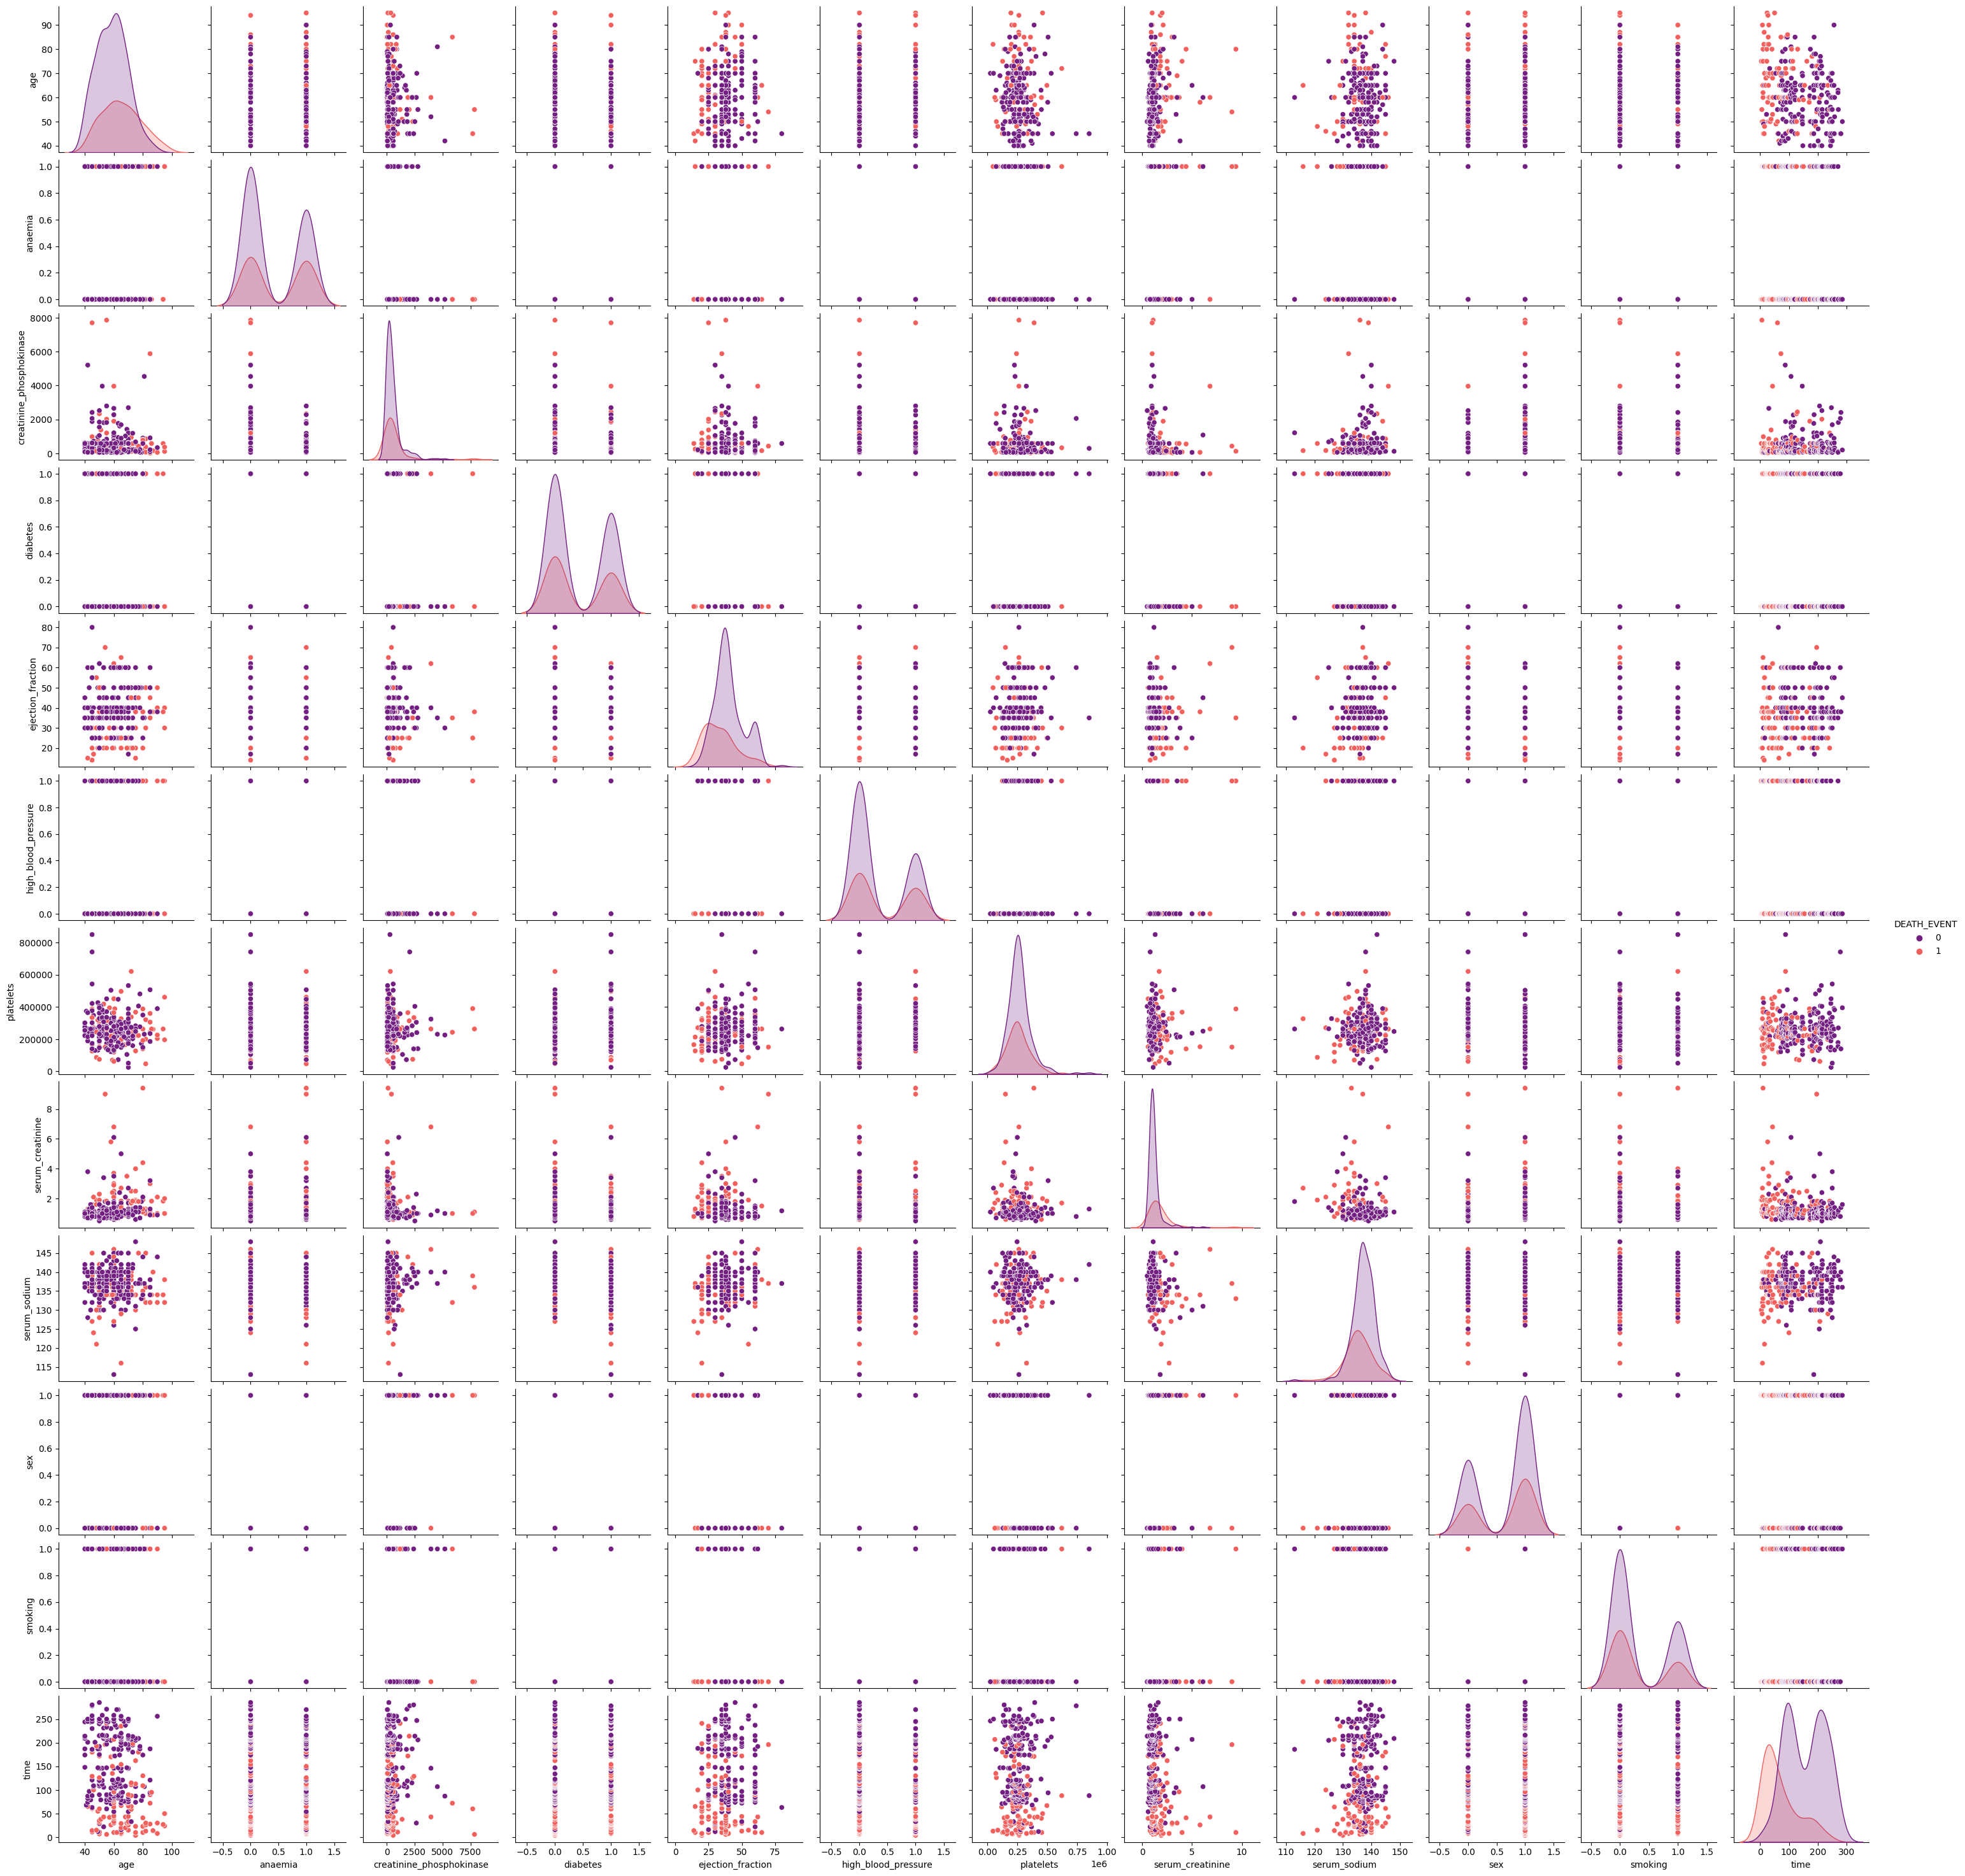

In [ ]:
# Display pair plot for data visualization
sns.pairplot(df, hue = 'DEATH_EVENT', palette = 'magma')
plt.show()

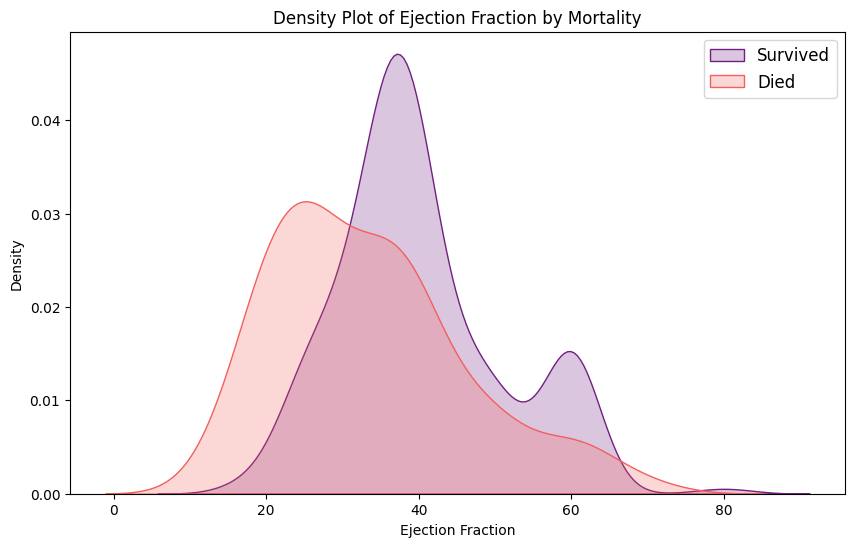

In [17]:
# Histogram
# Setting up the figure and axis
plt.figure(figsize=(10, 6))

# Define the colors from the "magma" palette
colors = sns.color_palette("magma", n_colors=2)

# KDE plots
sns.kdeplot(df[df['DEATH_EVENT'] == 0]['ejection_fraction'], label='Survived', shade=True, color=colors[0])
sns.kdeplot(df[df['DEATH_EVENT'] == 1]['ejection_fraction'], label='Died', shade=True, color=colors[1])

# Setting titles and labels
plt.title("Density Plot of Ejection Fraction by Mortality")
plt.xlabel("Ejection Fraction")
plt.ylabel("Density")
plt.legend(fontsize='large')  # Adjusting the font size of the legend

plt.show()

### Feature Engineering

(First, remove outliers from ejection fraction)
We decided to not remove them because the exploratory data analysis is based on the entire data and we cannot remove outliers from test data.

In [ ]:
"""
# Calculate Interquartile Range
Q1 = df['ejection_fraction'].quantile(0.25)
Q3 = df['ejection_fraction'].quantile(0.75)
IQR = Q3-Q1

# Filter out the outliers
data = df[~((df['ejection_fraction'] < (Q1 - 1.5 * IQR)) |
              (df['ejection_fraction'] > (Q3 + 1.5 * IQR)))]
"""

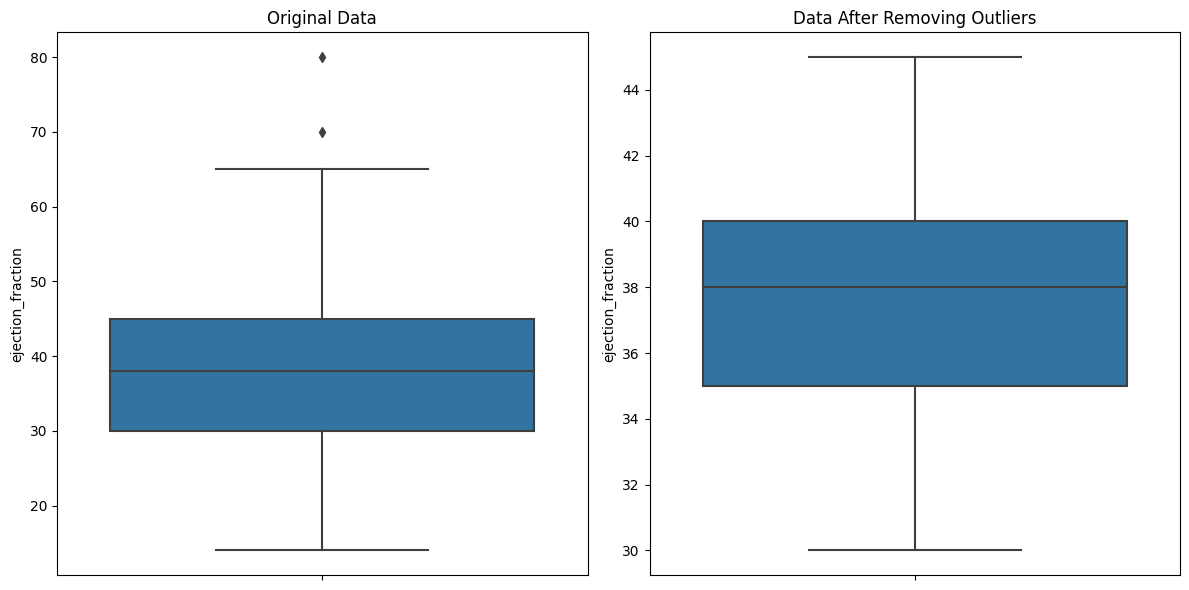

In [ ]:
"""
plt.figure(figsize=(12, 6))

# Original data
plt.subplot(1, 2, 1)
sns.boxplot(y=df['ejection_fraction'])
plt.title('Original Data')

# Data after removing outliers
plt.subplot(1, 2, 2)
sns.boxplot(y=data['ejection_fraction'])
plt.title('Data After Removing Outliers')

plt.tight_layout()
plt.show()
"""

## Logistic Regression

### Data Preparation

In [18]:
# Split the data into features and target variable
X = df.drop(['DEATH_EVENT', 'time'], axis = 1)
y = df['DEATH_EVENT']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

# Initialize SMOTE and oversample the data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Normalizing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

### Model 1: Excluded `time` and `DEATH_EVENT`

In [19]:
# Train logistic regression model
log_reg = LogisticRegression(penalty = 'l2', C = 1.0, solver = 'liblinear')
log_reg.fit(X_train_scaled, y_train_resampled)

# Use the model to make predictions on the testing data
y_pred = log_reg.predict(X_test_scaled)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[29  6]
 [12 13]]

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.83      0.76        35
           1       0.68      0.52      0.59        25

    accuracy                           0.70        60
   macro avg       0.70      0.67      0.68        60
weighted avg       0.70      0.70      0.69        60



The precision of the model on the "no death" class is 71%, meaning that 71% of observation that was predicted to death have the outcome of death. However, the model was only able to correctly identify 52% of all actual death cases.  

In [20]:
import statsmodels.api as sm

# Add a constant term for the intercept
X = sm.add_constant(X_train_scaled)

# Create and fit logistic regression model
log_reg = sm.Logit(y_train_resampled, X).fit()

# Get summary report
summary = log_reg.summary()
print(summary)

Optimization terminated successfully.
         Current function value: 0.461971
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            DEATH_EVENT   No. Observations:                  336
Model:                          Logit   Df Residuals:                      324
Method:                           MLE   Df Model:                           11
Date:                Tue, 03 Oct 2023   Pseudo R-squ.:                  0.3335
Time:                        15:55:42   Log-Likelihood:                -155.22
converged:                       True   LL-Null:                       -232.90
Covariance Type:            nonrobust   LLR p-value:                 1.200e-27
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0500      0.145     -0.346      0.730      -0.333       0.233
x1             0.8843      0.

The Pseudo R-squared value is 0.3335, suggesting that the model explains about 33.35% of the variability in the death event outcome.

### Model 2

Remove features with insignificant p-values and wide confidence intervals.

In [21]:
# Split the data into features and target variable
X = df.drop(['DEATH_EVENT', 'time', 'anaemia', 'diabetes',
             'creatinine_phosphokinase','high_blood_pressure', 'platelets',
             'serum_sodium', 'smoking'], axis = 1)
y = df['DEATH_EVENT']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

# Initialize SMOTE and oversample the data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Normalizing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression model
log_reg2 = LogisticRegression(penalty = 'l2', C = 1.0, solver = 'liblinear')
log_reg2.fit(X_train_scaled, y_train_resampled)

# Use the model to make predictions on the testing data
y_pred = log_reg2.predict(X_test_scaled)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[25 10]
 [13 12]]

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.71      0.68        35
           1       0.55      0.48      0.51        25

    accuracy                           0.62        60
   macro avg       0.60      0.60      0.60        60
weighted avg       0.61      0.62      0.61        60



The accuracy of the second model on the test set decreased slightly to 62%. The precisions and recalls for both death and no death decreases as well.

Model summary

In [22]:
# Add a constant term for the intercept
X = sm.add_constant(X_train_scaled)

# Create and fit logistic regression model
log_reg = sm.Logit(y_train_resampled, X).fit()

# Get summary report
summary = log_reg.summary()
print(summary)

Optimization terminated successfully.
         Current function value: 0.515333
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            DEATH_EVENT   No. Observations:                  336
Model:                          Logit   Df Residuals:                      331
Method:                           MLE   Df Model:                            4
Date:                Tue, 03 Oct 2023   Pseudo R-squ.:                  0.2565
Time:                        15:55:49   Log-Likelihood:                -173.15
converged:                       True   LL-Null:                       -232.90
Covariance Type:            nonrobust   LLR p-value:                 6.860e-25
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0472      0.138      0.341      0.733      -0.224       0.318
x1             0.8125      0.

The Pseudo R-sqared value indicates that this model explains about 25.65% of the variability in the death event outcome. The reduction in model complexity resulted in a decrease in predictive accuracy. This suggests that some of the variables that were dropped might have useful predictive information when combined with others.

## KNN

In [23]:
df_deathonly = df[df['DEATH_EVENT'] != 0]
df_deathonly.rename(columns={'time': 'time_to_death'}, inplace=True)
df_deathonly.drop(columns={'DEATH_EVENT'}, inplace=True)
print("The length of the original dataframe is:", df.shape[0])
print("The length of the new dataframe is:", df_deathonly.shape[0])
df_deathonly.head()

The length of the original dataframe is: 299
The length of the new dataframe is: 96


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time_to_death
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8


In [ ]:
"""
# Extracting the feature and target variable
X_multi = df_deathonly[['age','anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking']]
y = df_deathonly['time_to_death']

# Splitting the data into training and testing sets
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y, test_size=0.2, random_state=42)

# Create and fit the model
mlr_model = LinearRegression()
mlr_model.fit(X_train_multi, y_train_multi)

# Predictions
y_pred_multi = mlr_model.predict(X_test_multi)

# Evaluating the model
print(f'Mean Squared Error (MLR): {mean_squared_error(y_test_multi, y_pred_multi)}')
print(f'R2 Score (MLR): {r2_score(y_test_multi, y_pred_multi)}')
"""

Mean Squared Error (MLR): 4031.871996843403
R2 Score (MLR): 0.021090916920368352


The length of the dataframe is: 299
The max K value is: 17


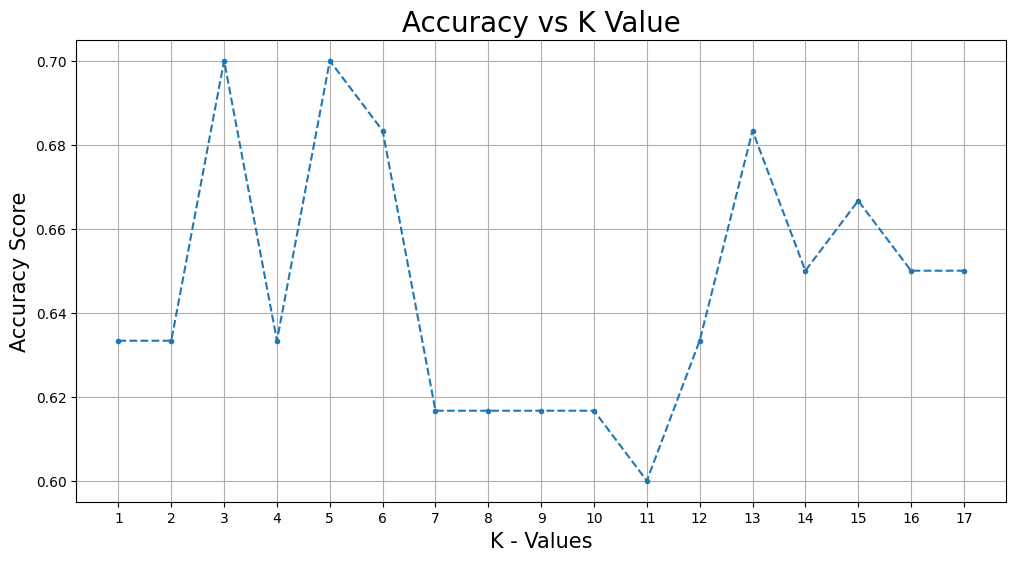

The best K value is: 3
Train Accuracy: 84.94%
Test Accuracy: 70.00%
[[33  2]
 [16  9]]
              precision    recall  f1-score   support

           0       0.67      0.94      0.79        35
           1       0.82      0.36      0.50        25

    accuracy                           0.70        60
   macro avg       0.75      0.65      0.64        60
weighted avg       0.73      0.70      0.67        60



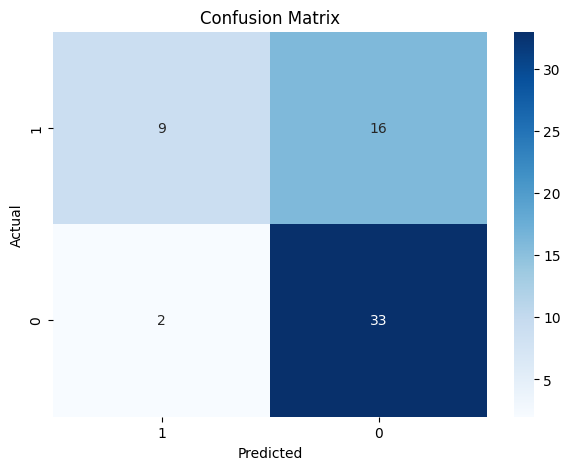

In [24]:

#STEP 4: Split data into features and label
X = df.drop(columns=['time','DEATH_EVENT','anaemia','diabetes','high_blood_pressure','sex','smoking'])
y = df['DEATH_EVENT']


#STEP 5: Find Optimal K

# Calculate the maximum k value as the square root of rows_nbr
max_k = int(np.sqrt(df.shape[0]))
print("The length of the dataframe is:", df.shape[0])
print("The max K value is:", max_k)

# Initializing lists to store accuracies
accuracies = []

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Iterating over k-values to find the optimal one
for i in range(1, max_k + 1):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plotting accuracy vs k-values
plt.figure(figsize=(12,6))
plt.plot(range(1, max_k + 1), accuracies, marker="o", linestyle="dashed", markersize=3)
plt.title("Accuracy vs K Value", fontsize=20)
plt.xlabel("K - Values", fontsize=15)
plt.ylabel("Accuracy Score", fontsize=15)
plt.xticks(range(1, max_k + 1))
plt.grid(True)
plt.show()

# STEP 6: Apply KNN with best K
best_k = accuracies.index(max(accuracies)) + 1  # +1 because index starts at 0
print(f"The best K value is: {best_k}")
#STEP 6: Apply KNN

# Final split into train and test RS 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# The best K value from a combination of class 1 Prec and Accuracy seems to be at K=20
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Predict using the test data
y_pred = knn.predict(X_test)

# Train accuracy
y_train_pred = knn.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")

# Test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

#Create confusion matrix
# Get unique classes
classes = df['DEATH_EVENT'].unique()

# Plotting the confusion matrix
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, y_pred, labels=classes), cmap='Blues', annot=True, fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

The length of the dataframe is: 299
The max K value is: 17


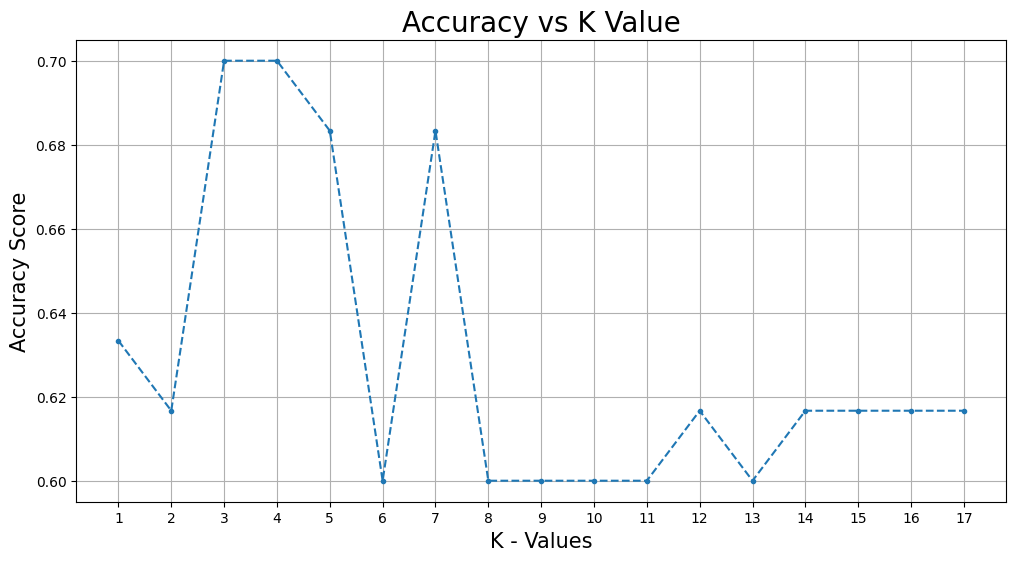

The best K value is: 3
Train Accuracy: 71.55%
Test Accuracy: 70.00%
[[28  7]
 [11 14]]
              precision    recall  f1-score   support

           0       0.72      0.80      0.76        35
           1       0.67      0.56      0.61        25

    accuracy                           0.70        60
   macro avg       0.69      0.68      0.68        60
weighted avg       0.70      0.70      0.70        60



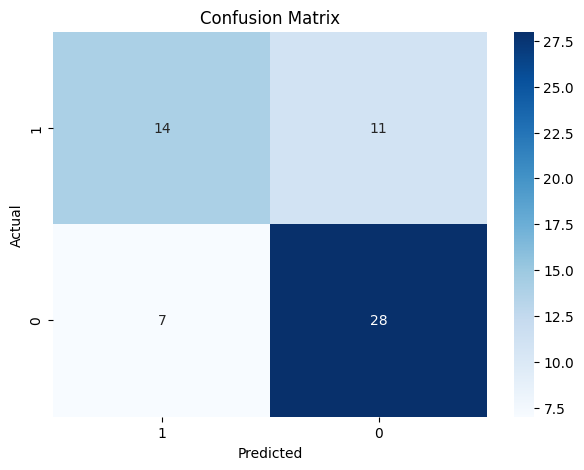

In [25]:

#STEP 4: Split data into features and label
X = df[['ejection_fraction']]
y = df['DEATH_EVENT']


#STEP 5: Find Optimal K

# Calculate the maximum k value as the square root of rows_nbr
max_k = int(np.sqrt(df.shape[0]))
print("The length of the dataframe is:", df.shape[0])
print("The max K value is:", max_k)

# Initializing lists to store accuracies
accuracies = []

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Iterating over k-values to find the optimal one
for i in range(1, max_k + 1):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plotting accuracy vs k-values
plt.figure(figsize=(12,6))
plt.plot(range(1, max_k + 1), accuracies, marker="o", linestyle="dashed", markersize=3)
plt.title("Accuracy vs K Value", fontsize=20)
plt.xlabel("K - Values", fontsize=15)
plt.ylabel("Accuracy Score", fontsize=15)
plt.xticks(range(1, max_k + 1))
plt.grid(True)
plt.show()

# STEP 6: Apply KNN with best K
best_k = accuracies.index(max(accuracies)) + 1  # +1 because index starts at 0
print(f"The best K value is: {best_k}")
#STEP 6: Apply KNN

# Final split into train and test RS 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# The best K value from a combination of class 1 Prec and Accuracy seems to be at K=20
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Predict using the test data
y_pred = knn.predict(X_test)

# Train accuracy
y_train_pred = knn.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")

# Test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

#Create confusion matrix
# Get unique classes
classes = df['DEATH_EVENT'].unique()

# Plotting the confusion matrix
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, y_pred, labels=classes), cmap='Blues', annot=True, fmt='g', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Result Visualization

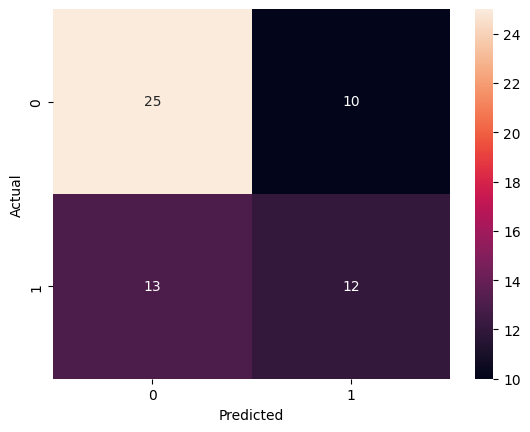

In [26]:
# Visualizing confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Further Exploration of the Features

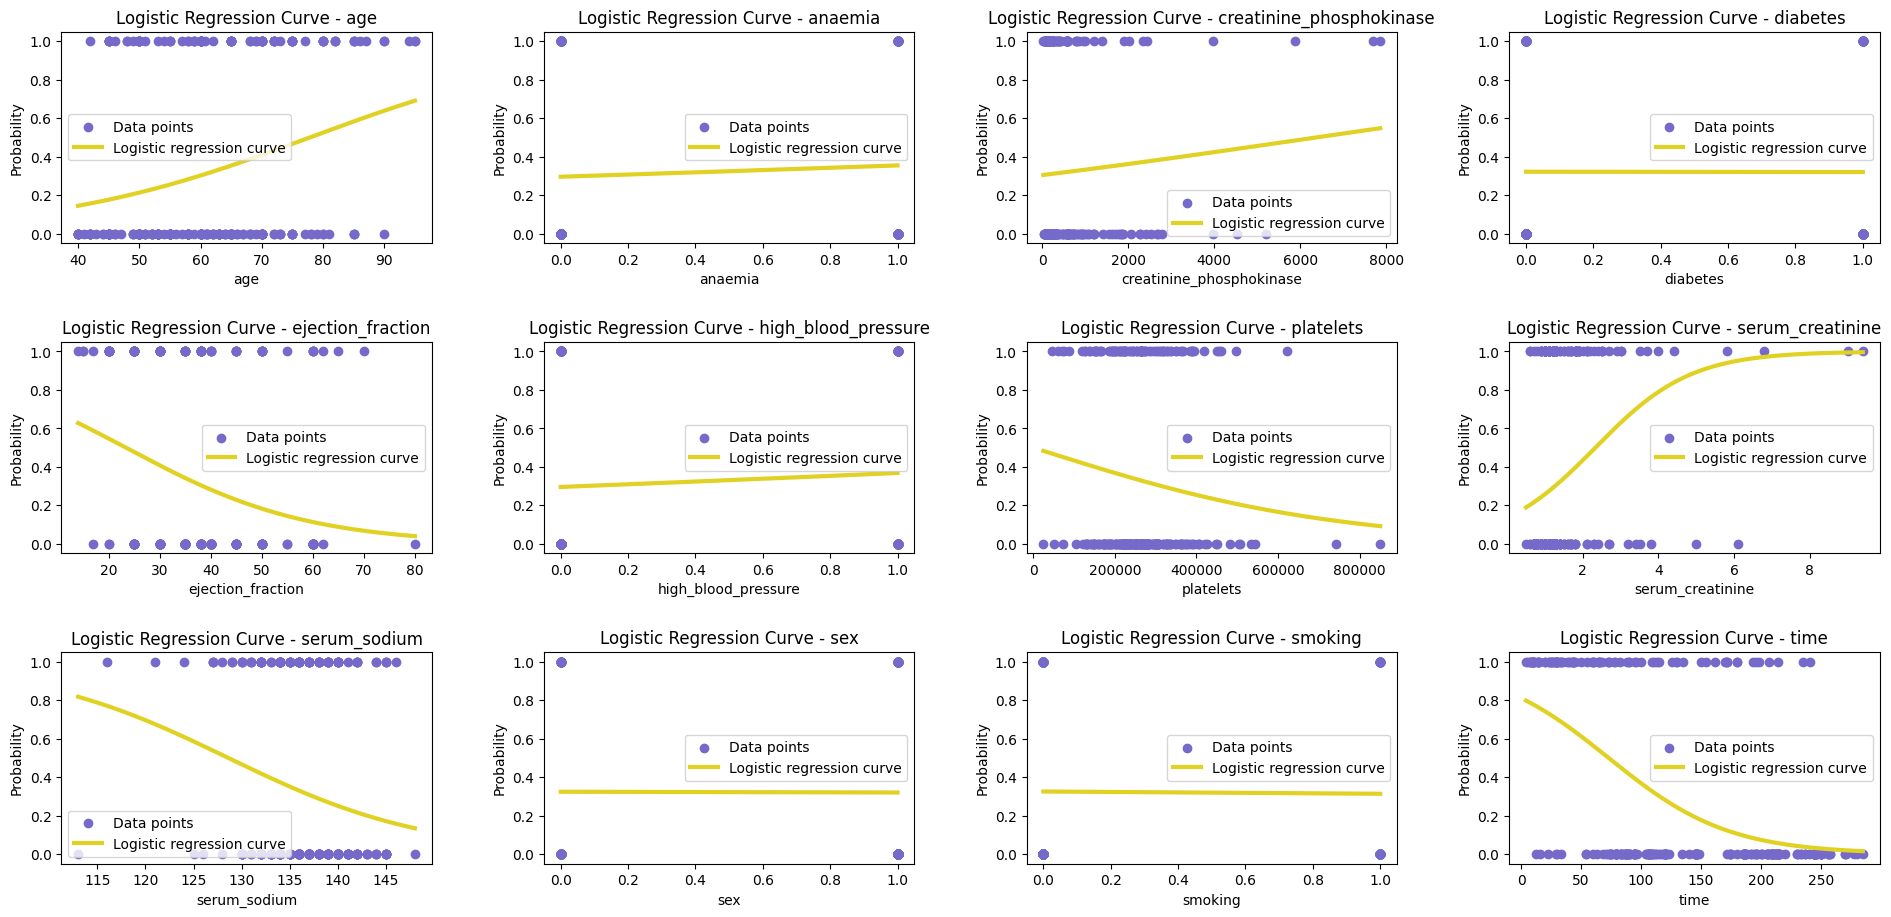

In [27]:
# Create logistic regression object
log_reg = LogisticRegression()

fig, axs = plt.subplots(3, 4, figsize=(20, 10))
fig.tight_layout(pad=5.0)  # Adds padding between subplots

for i, feature in enumerate(df.columns[:-1]):  # Exclude 'Outcome' column
    row = i // 4  # Determine row index
    col = i % 4   # Determine column index

    # Reshape the feature and outcome arrays to fit the model
    X = df[[feature]]
    y = df['DEATH_EVENT']

    # Fit logistic regression model
    log_reg.fit(X, y)

    # Get min and max values of the feature for plotting
    x_test = np.linspace(X.min(), X.max(), 300)

    # Get the probability for each value in the range
    prob = log_reg.predict_proba(x_test)[:, 1]

    # Plot the data points
    axs[row, col].scatter(X, y, color='#7569c9', label='Data points')

    # Plot the sigmoid curve
    axs[row, col].plot(x_test, prob, color='#e0d122', lw=3, label='Logistic regression curve' )

    axs[row, col].set_title(f'Logistic Regression Curve - {feature}')
    axs[row, col].set_xlabel(feature)
    axs[row, col].set_ylabel('Probability')
    axs[row, col].legend()

plt.show()

# Appendix

Data Transformation

In [ ]:
# df['CPK_label'] = pd.cut(x=df['creatinine_phosphokinase'], bins = [0, 120, 7861], labels = ['Normal','Elevated'])
# df['EF_label'] = pd.cut(x=df['ejection_fraction'], bins = [0, 30,40,51, 80], labels = ['Severely Abnormal','Moderately Abnormal', 'Mildly Abnormal', 'Normal'])
# df['Platelet_label'] = pd.cut(x=df['platelets'], bins = [25000,150000,450000,850000], labels = ['Thrombocytopenia','Normal', 'Thrombocytosis'])
# df['Cr_label'] = pd.cut(x=df['serum_creatinine'], bins = [0.5, 0.7, 1.3, 9.40], labels = ['Low Cr','Normal', 'High Cr'])
# df['Sodium_label'] = pd.cut(x=df['serum_sodium'], bins = [114, 120, 129, 135, 145, 148], labels = ['Severe Hyponatremia', 'Moderate Hyponatremia', 'Mild Hyponatremia','Normal', 'Hypernatremia'])
# print (df)